In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, boxcox
from scipy.stats.mstats import normaltest
from scipy.special import inv_boxcox
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore', module='sklearn')

In [2]:
df = pd.read_csv("E:/Spoorthi/Personal Project/Medical Insurance/Medicalpremium.csv")

In [3]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB


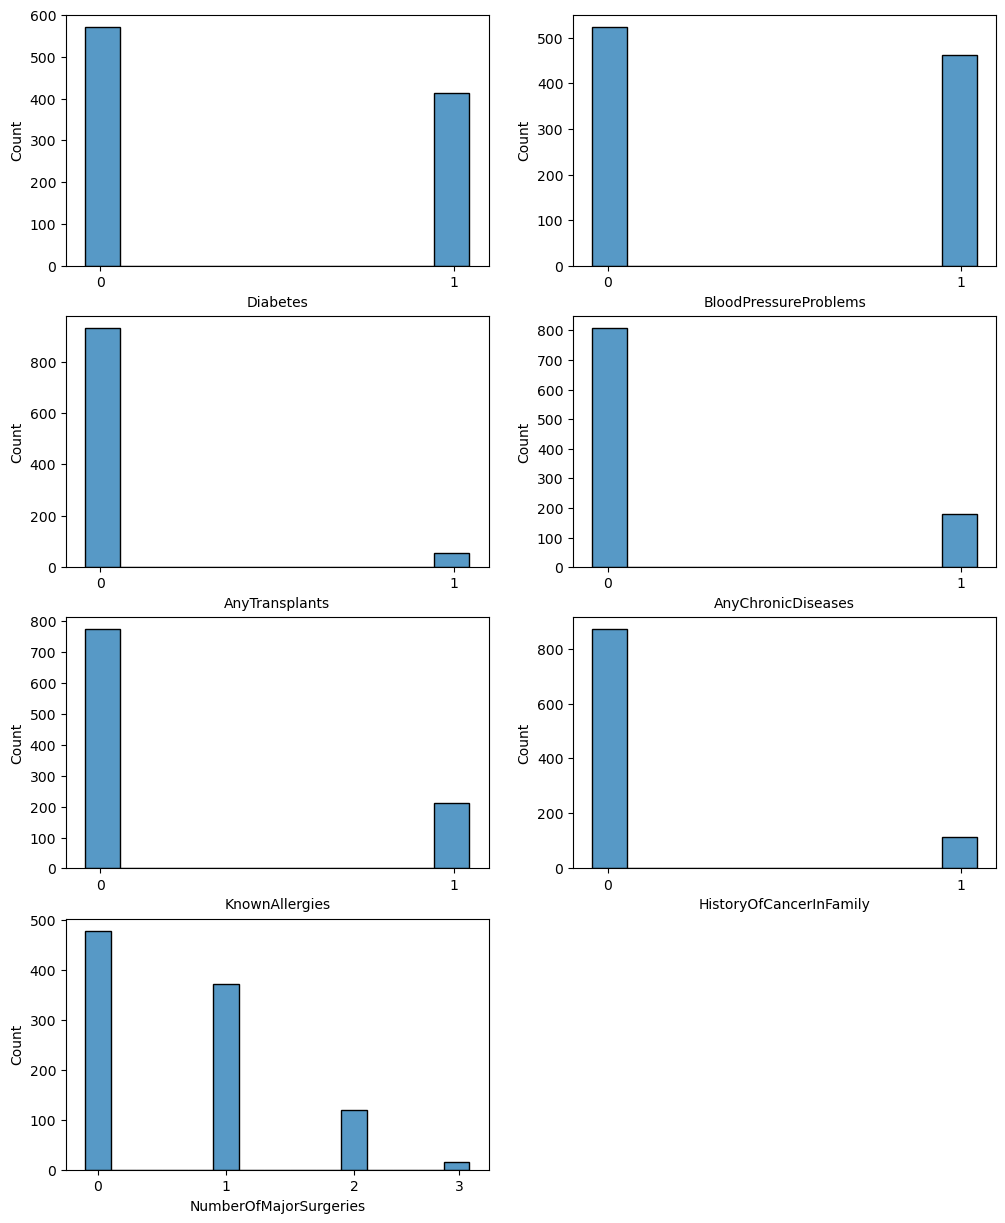

In [5]:
fig, ax  = plt.subplots(4,2, figsize=(12,15))
fig.delaxes(ax[3,1])

cols = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies',
      'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']

for num, col in enumerate(cols):
    ax_def = ax.ravel()[num]
    sns.histplot(df[col], ax=ax_def)
    
    if num==6:
        ax_def.set_xticks([0.1,1.1, 2.1, 2.92])
        ax_def.set_xticklabels([0, 1, 2, 3])
        continue
        
    ax_def.set_xticks([0.04,0.96])
    ax_def.set_xticklabels([0, 1])

In [6]:
df[['Age', 'Height', 'Weight', 'PremiumPrice']].describe()

,Age,Height,Weight,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000
mean,41.745436,168.182556,76.950304,24336.713996
std,13.963371,10.098155,14.265096,6248.184382
min,18.000000,145.000000,51.000000,15000.000000
25%,30.000000,161.000000,67.000000,21000.000000
50%,42.000000,168.000000,75.000000,23000.000000
75%,53.000000,176.000000,87.000000,28000.000000
max,66.000000,188.000000,132.000000,40000.000000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'PremiumPrice'}>]], dtype=object)

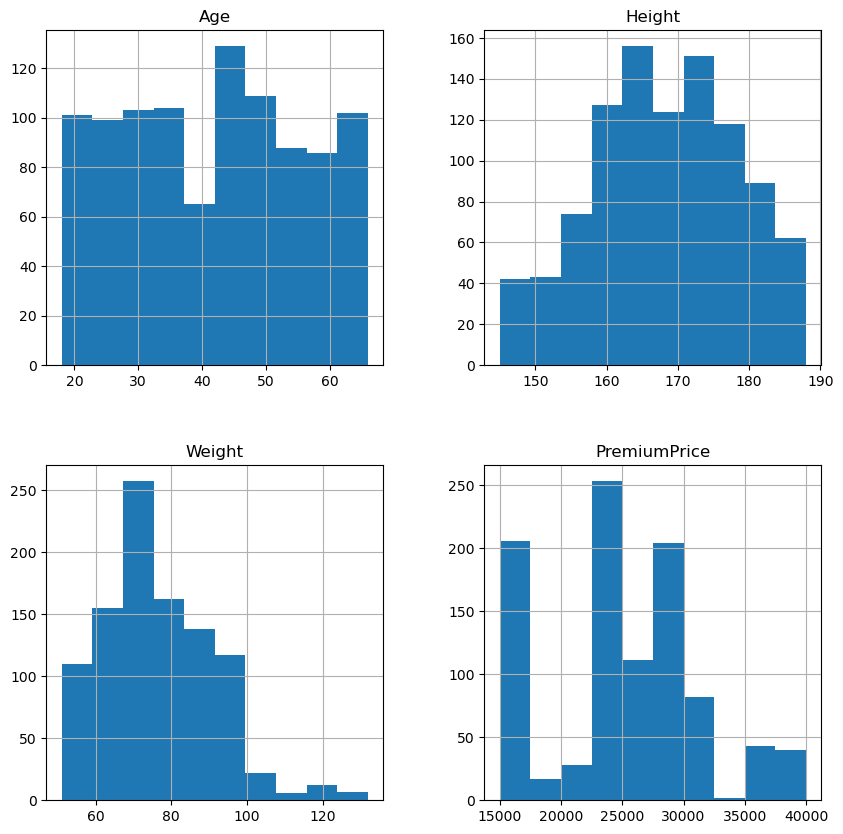

In [7]:
df[['Age', 'Height', 'Weight', 'PremiumPrice']].hist(figsize=(10,10))

[Text(0.5, 0, 'Price'), Text(0, 0.5, 'value')]

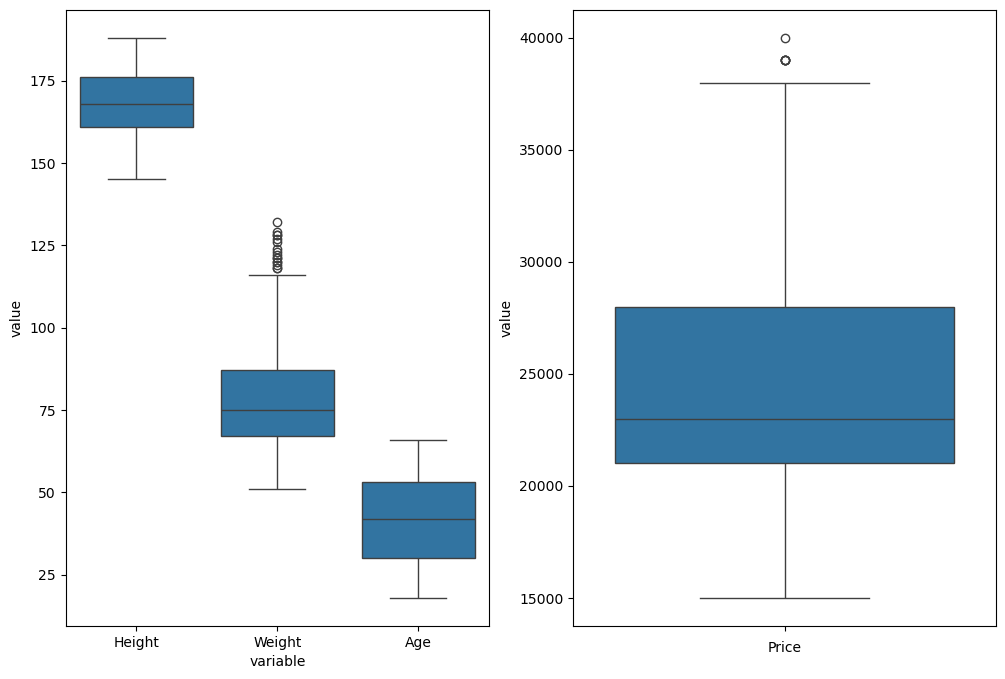

In [8]:
fig, axs = plt.subplots(1,2,figsize=(12,8))
sns.boxplot(x='variable', y='value', data=pd.melt(df[['Height', 'Weight', 'Age']]), ax=axs[0])
sns.boxplot(y='PremiumPrice',  data=df, ax=axs[1])
axs[1].set(xlabel='Price', ylabel='value')

In [9]:
weight_val = df['Weight'].describe()
weight_val

count    986.000000
mean      76.950304
std       14.265096
min       51.000000
25%       67.000000
50%       75.000000
75%       87.000000
max      132.000000
Name: Weight, dtype: float64

[Text(0.5, 0, 'Price'), Text(0, 0.5, 'value')]

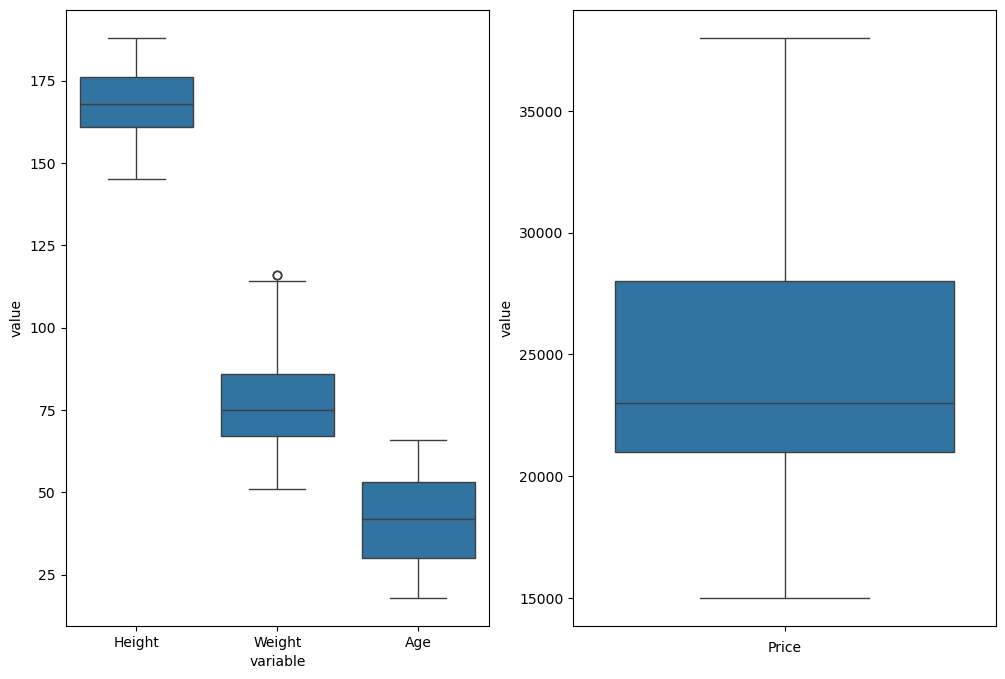

In [10]:
Q3_wei = df['Weight'].quantile(0.75)
Q1_wei = df['Weight'].quantile(0.25)
weight_lim = 1.5 * (Q3_wei - Q1_wei) + Q3_wei
Q3_pri = df['PremiumPrice'].quantile(0.75)
Q1_pri = df['PremiumPrice'].quantile(0.25)
price_lim = 1.5 * (Q3_pri - Q1_pri) + Q3_pri
df = df[(df['Weight']<weight_lim) &  (df['PremiumPrice']<price_lim)]
ig, axs = plt.subplots(1,2,figsize=(12,8))
sns.boxplot(x='variable', y='value', data=pd.melt(df[['Height', 'Weight', 'Age']]), ax=axs[0])
sns.boxplot(y='PremiumPrice',  data=df, ax=axs[1])
axs[1].set(xlabel='Price', ylabel='value')

In [11]:
df[['Age', 'Height', 'Weight', 'PremiumPrice']].corr()

,Age,Height,Weight,PremiumPrice
Age,1.000000,0.036674,-0.007651,0.719069
Height,0.036674,1.000000,0.080146,0.037199
Weight,-0.007651,0.080146,1.000000,0.157523
PremiumPrice,0.719069,0.037199,0.157523,1.000000


<Axes: xlabel='Height', ylabel='PremiumPrice'>

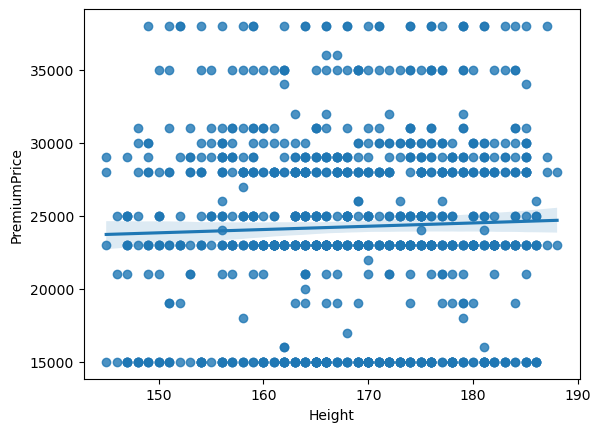

In [12]:
sns.regplot(x='Height', y='PremiumPrice', data=df)

In [13]:
df.drop(columns=['Height'], axis=1, inplace=True)

In [14]:
df_noDiabetes = df.groupby('Diabetes').get_group(0)['PremiumPrice']
df_Diabetes = df.groupby('Diabetes').get_group(1)['PremiumPrice']
f_oneway(df_noDiabetes, df_Diabetes)

F_onewayResult(statistic=6.1277473125365365, pvalue=0.013478739494738259)

In [15]:
df_noBP = df.groupby('BloodPressureProblems').get_group(0)['PremiumPrice']
df_BP = df.groupby('BloodPressureProblems').get_group(1)['PremiumPrice']
f_oneway(df_noBP, df_BP)

F_onewayResult(statistic=24.422144169163662, pvalue=9.121787503867382e-07)

In [16]:
df_noT = df.groupby('AnyTransplants').get_group(0)['PremiumPrice']
df_T = df.groupby('AnyTransplants').get_group(1)['PremiumPrice']
f_oneway(df_noT, df_T)

F_onewayResult(statistic=91.17626361865224, pvalue=1.0476959317316363e-20)

In [17]:
df_noCD = df.groupby('AnyChronicDiseases').get_group(0)['PremiumPrice']
df_CD = df.groupby('AnyChronicDiseases').get_group(1)['PremiumPrice']
f_oneway(df_noCD, df_CD)

F_onewayResult(statistic=45.18015081323932, pvalue=3.073526340293322e-11)

In [18]:
df_noKA = df.groupby('KnownAllergies').get_group(0)['PremiumPrice']
df_KA = df.groupby('KnownAllergies').get_group(1)['PremiumPrice']
f_oneway(df_noKA, df_KA)

F_onewayResult(statistic=0.0983333860406225, pvalue=0.7539067857633162)

In [19]:
df_noHC = df.groupby('HistoryOfCancerInFamily').get_group(0)['PremiumPrice']
df_HC = df.groupby('HistoryOfCancerInFamily').get_group(1)['PremiumPrice']
f_oneway(df_noHC, df_HC)

F_onewayResult(statistic=7.125705401041786, pvalue=0.007726528974575876)

In [20]:
df_NS0 = df.groupby('NumberOfMajorSurgeries').get_group(0)['PremiumPrice']
df_NS1 = df.groupby('NumberOfMajorSurgeries').get_group(1)['PremiumPrice']
df_NS2 = df.groupby('NumberOfMajorSurgeries').get_group(2)['PremiumPrice']
df_NS3 = df.groupby('NumberOfMajorSurgeries').get_group(3)['PremiumPrice']
f_oneway(df_NS0, df_NS1, df_NS2, df_NS3)

F_onewayResult(statistic=26.205968423877678, pvalue=2.6861256720698395e-16)

In [21]:
df.drop(columns=['KnownAllergies'], axis=1, inplace=True)

In [22]:
df['NumberOfMajorSurgeries'].value_counts()

NumberOfMajorSurgeries
0    470
1    363
2    116
3     16
Name: count, dtype: int64

In [23]:
df = pd.get_dummies(df, columns=['NumberOfMajorSurgeries'], drop_first=True)

In [24]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Weight,HistoryOfCancerInFamily,PremiumPrice,NumberOfMajorSurgeries_1,NumberOfMajorSurgeries_2,NumberOfMajorSurgeries_3
0,45,0,0,0,0,57,0,25000,False,False,False
1,60,1,0,0,0,73,0,29000,False,False,False
2,36,1,1,0,0,59,0,23000,True,False,False
3,52,1,1,0,1,93,0,28000,False,True,False
4,38,0,0,0,1,88,0,23000,True,False,False


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 965 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       965 non-null    int64
 1   Diabetes                  965 non-null    int64
 2   BloodPressureProblems     965 non-null    int64
 3   AnyTransplants            965 non-null    int64
 4   AnyChronicDiseases        965 non-null    int64
 5   Weight                    965 non-null    int64
 6   HistoryOfCancerInFamily   965 non-null    int64
 7   PremiumPrice              965 non-null    int64
 8   NumberOfMajorSurgeries_1  965 non-null    bool 
 9   NumberOfMajorSurgeries_2  965 non-null    bool 
 10  NumberOfMajorSurgeries_3  965 non-null    bool 
dtypes: bool(3), int64(8)
memory usage: 70.7 KB


<Axes: >

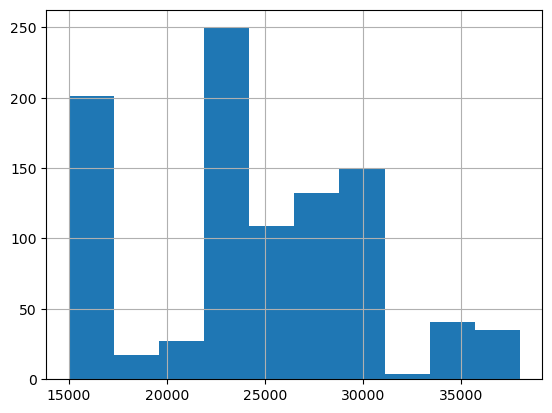

In [26]:
df.PremiumPrice.hist()

In [27]:
normaltest(df.PremiumPrice)

NormaltestResult(statistic=16.11967946721973, pvalue=0.0003159774418077449)

In [28]:
PriceTrans, lmbda = boxcox(df.PremiumPrice)
print('The obtained value for lambda by boxcox transformation: %0.3f ' %lmbda)

The obtained value for lambda by boxcox transformation: 0.813 


In [29]:
normaltest(PriceTrans)

NormaltestResult(statistic=23.893719841226062, pvalue=6.479547238694233e-06)

<Axes: >

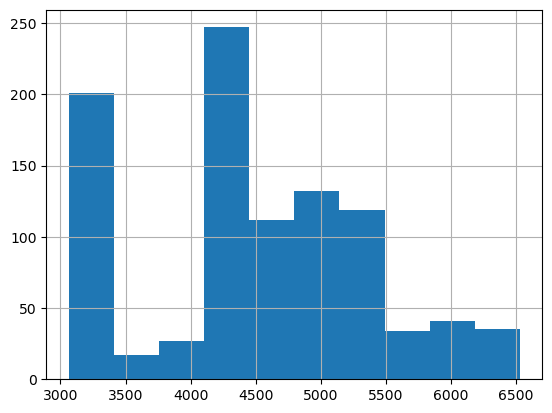

In [30]:
df['PremiumPrice'] = PriceTrans
df['PremiumPrice'].hist()

In [31]:
X = df.drop(columns=['PremiumPrice'], axis=1)
y = df.PremiumPrice

In [32]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25,random_state=1979, shuffle=True)
scaler = StandardScaler()
X_tr_sc = X_tr.copy()
X_tr_sc[['Age', 'Weight']] = scaler.fit_transform(X_tr[['Age', 'Weight']])
lr = LinearRegression()
lr.fit(X_tr_sc, y_tr)
X_te_sc = X_te.copy()
X_te_sc[['Age', 'Weight']] = scaler.transform(X_te[['Age', 'Weight']])
y_te_pr = lr.predict(X_te_sc)
# since we have already transformed the premium price to have normally distributed 
# values, to evaluate the model we revert it back to the true values using inv_boxcox
# with the same value for lmbda = 0.813
y_te_true = inv_boxcox(y_te, lmbda)
y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
print('The R2 Score: ', r2_score(y_true=y_te_true, y_pred=y_te_pr_true))

The R2 Score:  0.652734901906623


In [33]:
lr_res = pd.DataFrame(zip(X_tr.columns.tolist(),lr.coef_)).rename({0:'Feature', 1:'Coefficient'}, axis=1)
lr_res.loc[len(lr_res.index)] = ['Intercept', lr.intercept_]
lr_res

,Feature,Coefficient
0,Age,727.534148
1,Diabetes,-13.968121
2,BloodPressureProblems,-29.841239
3,AnyTransplants,1361.886305
4,AnyChronicDiseases,382.654952
5,Weight,156.650135
6,HistoryOfCancerInFamily,292.020995
7,NumberOfMajorSurgeries_1,41.071993
8,NumberOfMajorSurgeries_2,-260.953789
9,NumberOfMajorSurgeries_3,-389.497585


[Text(0.5, 0, 'Ground truth'),
 Text(0, 0.5, 'Prediction'),
 Text(0.5, 1.0, 'Predicted versus True Premium Price')]

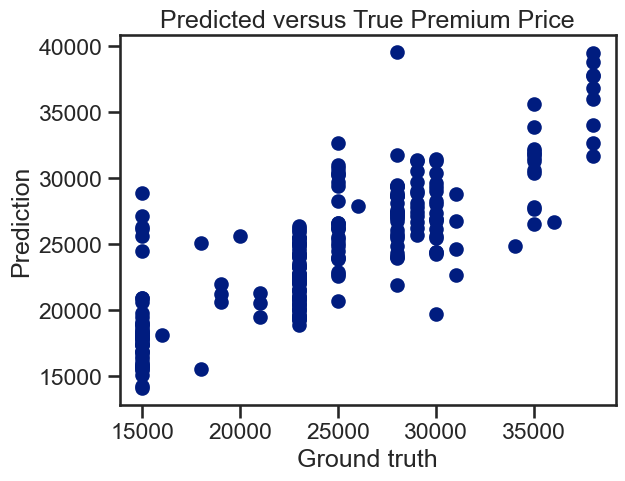

In [34]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')
plt.scatter(x=y_te_true, y=y_te_pr_true)
ax = plt.gca()
ax.set(xlabel='Ground truth', ylabel='Prediction', title='Predicted versus True Premium Price')

The best R2 score equal to 0.716 for linear regression using Ridge
is obtained with alpha = 1.072.


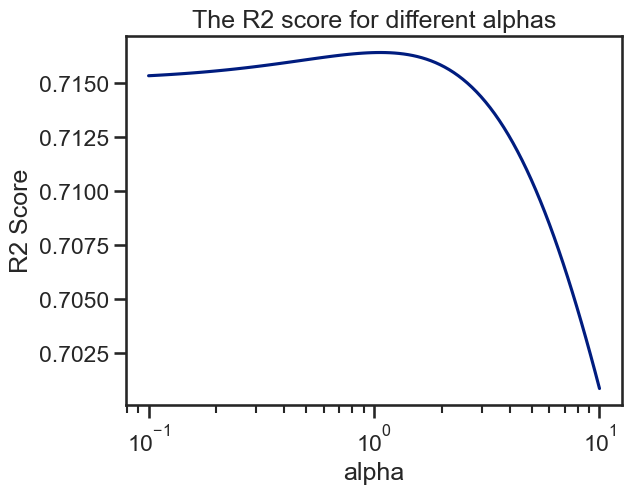

In [35]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_po = poly.fit_transform(X)
X_po_tr, X_po_te, y_tr, y_te = train_test_split(X_po, y, test_size=0.3, shuffle=True, random_state=1979)
scaler_po = StandardScaler()
X_po_tr_sc = scaler_po.fit_transform(X_po_tr)
ridge_alphas = np.geomspace(1e-1,1e1,100)
y_te_true = inv_boxcox(y_te, lmbda)
ridge_res = list()
for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)
    ridge.fit(X_po_tr_sc, y_tr)
    X_po_te_sc = scaler_po.transform(X_po_te)
    y_te_pr = ridge.predict(X_po_te_sc)
    y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
    ridge_res.append(r2_score(y_true=y_te_true, y_pred=y_te_pr_true))
ax =plt.axes()
ax.semilogx(ridge_alphas, ridge_res)
ax.set(xlabel='alpha', ylabel='R2 Score', title='The R2 score for different alphas')
print('''The best R2 score equal to {0:1.3f} for linear regression using Ridge
is obtained with alpha = {1:1.3f}.'''.format(np.max(ridge_res), ridge_alphas[np.argmax(ridge_res)]))

In [36]:
ridge_alpha_best = ridge_alphas[np.argmax(ridge_res)]
ridge = Ridge(alpha=ridge_alpha_best, max_iter=100000)
ridge.fit(X_po_tr_sc, y_tr)
y_te_pr = ridge.predict(X_po_te_sc)
y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
ridge_rmse = mean_squared_error(y_true=y_te_true, y_pred=y_te_pr_true, squared=False )
print('The sum of coefficients obtained by Ridge: %4.4f' %abs(ridge.coef_).sum())
print('The number of zero coefficients equal to %i.' %len(ridge.coef_[ridge.coef_==0]))
print('''The root mean squared error (rmse) equal to {0:1.3f} for linear regression using Ridge
is obtained with alpha = {1:1.3f}.'''.format(ridge_rmse, ridge_alphas[np.argmax(ridge_res)]))

The sum of coefficients obtained by Ridge: 8817.9728
The number of zero coefficients equal to 6.
The root mean squared error (rmse) equal to 3271.728 for linear regression using Ridge
is obtained with alpha = 1.072.


In [37]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_po_tr_sc, y_tr)
lasso_alphas = lasso_cv.alphas_
lasso_res = lasso_cv.mse_path_
lasso_alpha_best = lasso_alphas[np.argmax(lasso_res)]
lasso = Lasso(alpha=lasso_alpha_best, max_iter=100000)
lasso.fit(X_po_tr_sc, y_tr)
y_te_pr = lasso.predict(X_po_te_sc)
y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
lasso_rmse = mean_squared_error(y_true=y_te_true, y_pred=y_te_pr_true, squared=False )
print('The sum of coefficients obtained by Lasso: %4.4f' %abs(lasso.coef_).sum())
print('The number of zero coefficients equal to %i.' %len(lasso.coef_[lasso.coef_==0]))
print('''The root mean squared error (rmse) equal to {0:1.3f} for linear regression using Lasso
is obtained with alpha = {1:1.3f}.'''.format(lasso_rmse, lasso_alphas[np.argmax(lasso_res)]))

The sum of coefficients obtained by Lasso: 0.0000
The number of zero coefficients equal to 64.
The root mean squared error (rmse) equal to 6156.887 for linear regression using Lasso
is obtained with alpha = 672.858.


The best R2 score equal to 0.716 for linear regression using Elastic Net is obtained with alpha = 0.003.


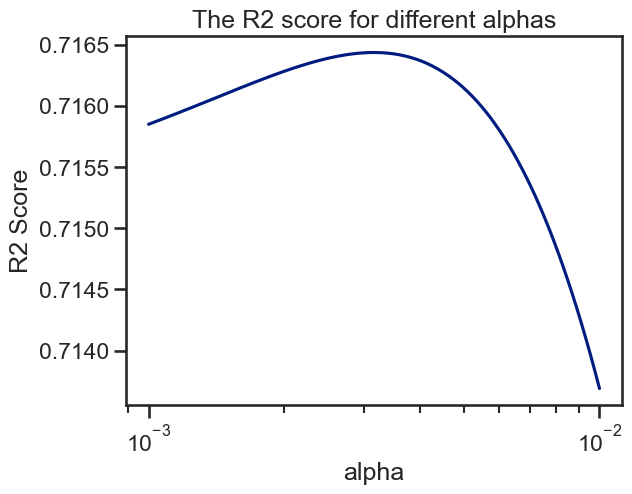

In [38]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_po = poly.fit_transform(X)
X_po_tr, X_po_te, y_tr, y_te = train_test_split(X_po, y, test_size=0.3, shuffle=True, random_state=1979)
scaler_po = StandardScaler()
X_po_tr_sc = scaler_po.fit_transform(X_po_tr)
elastic_alphas = np.geomspace(1e-3,1e-2,100)
y_te_true = inv_boxcox(y_te, lmbda)
elastic_res = list()
for alpha in elastic_alphas:
    elastic = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000)
    elastic.fit(X_po_tr_sc, y_tr)
    X_po_te_sc = scaler_po.transform(X_po_te)
    y_te_pr = elastic.predict(X_po_te_sc)
    y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
    elastic_res.append(r2_score(y_true=y_te_true, y_pred=y_te_pr_true))
ax = plt.axes()
ax.semilogx(elastic_alphas, elastic_res)
ax.set(xlabel='alpha', ylabel='R2 Score', title='The R2 score for different alphas')
print('''The best R2 score equal to {0:1.3f} for linear regression using Elastic Net is obtained with alpha = {1:1.3f}.'''.format(np.max(elastic_res), elastic_alphas[np.argmax(elastic_res)]))

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a scaler object
scaler = StandardScaler()
# Fit the scaler to your training features and transform both training and test features
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
# Assuming you want to use the scaled test features for prediction
X_te_po_sc = X_test_sc

In [40]:
X['new1'] = X['Weight'] / X['Age'] 
X['new2'] = X['Diabetes'] * X['BloodPressureProblems'] * X['AnyTransplants'] * X['AnyChronicDiseases']

In [41]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=1979, shuffle=True)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_tr_po = poly.fit_transform(X_tr)
scaler_po = StandardScaler()
X_tr_po_sc = scaler_po.fit_transform(X_tr_po)
y_te_true = inv_boxcox(y_te, lmbda)
X_te_po = poly.transform(X_te)
X_te_po_sc = scaler_po.transform(X_te_po)
alphas = np.geomspace(1e-3,1e3,1000)
kf = KFold(n_splits=5, shuffle=True, random_state=1980)
lasCV = LassoCV(alphas=alphas, cv=kf)
ridCV = RidgeCV(alphas=alphas, cv=kf)
elaCV = ElasticNetCV(alphas=alphas, l1_ratio=0.5, cv=kf)
estimators = [lasCV, ridCV, elaCV]
R2 = list()
RMSE = list()
for estimator in estimators:
    estimator.fit(X_tr_po_sc, y_tr)
    y_te_pr = estimator.predict(X_te_po_sc)
    y_te_pr_true = inv_boxcox(y_te_pr, lmbda) 
    r2 = r2_score(y_true=y_te_true , y_pred=y_te_pr_true)
    rmse = mean_squared_error(y_true=y_te_true, y_pred=y_te_pr_true, squared=False) 
    R2.append(r2), RMSE.append(rmse)
pd.DataFrame({'R2 score': R2, 'RMSE': RMSE}, index=['Ridge', 'Lasso', 'Elastic Net'] )

,R2 score,RMSE
Ridge,0.759160,3029.111046
Lasso,0.758380,3034.009956
Elastic Net,0.758525,3033.095755


Text(0, 0.5, 'Value')

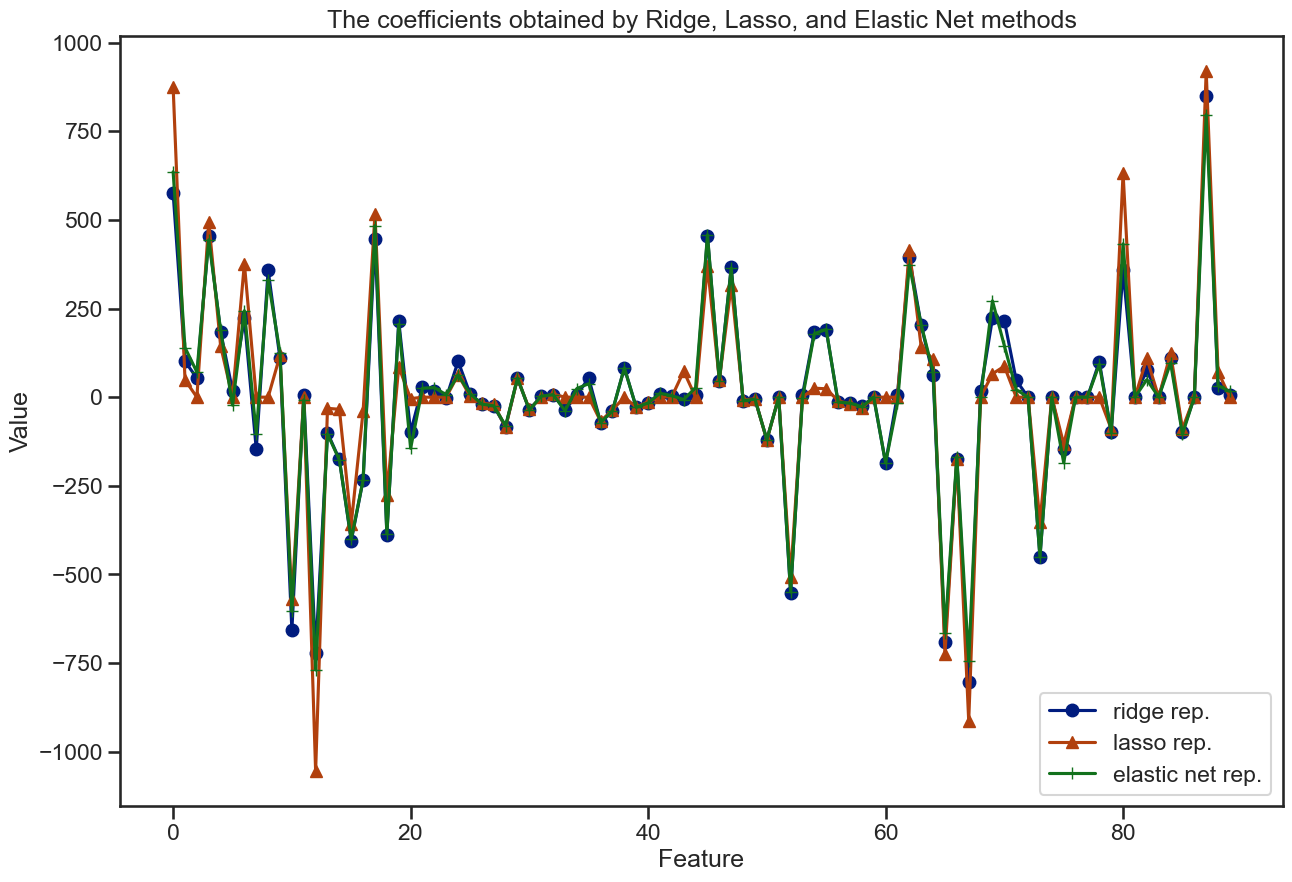

In [42]:
colors = sns.color_palette()
fig = plt.figure(figsize=(15,10))
plt.plot(ridCV.coef_, color=colors[0], marker='o', label='ridge rep.')
plt.plot(lasCV.coef_, color=colors[1], marker='^', label='lasso rep.')
plt.plot(elaCV.coef_, color=colors[2], marker='+', label='elastic net rep.')
plt.legend()
plt.title('The coefficients obtained by Ridge, Lasso, and Elastic Net methods')
plt.xlabel('Feature')
plt.ylabel('Value')

In [43]:
scaler_list = [MaxAbsScaler(), MinMaxScaler(), StandardScaler()]
alphas = np.geomspace(1e-2,1e2, 100)
poly = PolynomialFeatures(degree=2)
kf = KFold(n_splits=5, shuffle=True, random_state=1979)
scores = list()
alpha_val = list()
scaler_val = list()
for sca in scaler_list:
    for alpha in alphas:
        las = Lasso(alpha=alpha)
        estimator = Pipeline([('Polynomial_features', poly), ('scaler', sca), ('lasso_reg', las)])
        scaler_val.append(sca)
        predictions = cross_val_predict(estimator, X, y, cv=kf)
        scores.append(r2_score(y_true=y, y_pred=predictions))
        alpha_val.append(alpha)
RES = pd.DataFrame({'alpha':alpha_val, 'Scaler':scaler_val, 'R2 score':scores})
print('The best scaler: \n', RES[ RES['R2 score']== RES['R2 score'].max()] )

The best scaler: 
         alpha          Scaler  R2 score
126  0.112332  MinMaxScaler()  0.754776


In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state=1979)
poly = PolynomialFeatures()
sca = StandardScaler()
las = Ridge()
alphas= np.geomspace(1e-2, 1e2, num=100)
estimator = Pipeline([('Polynomial_features', poly),('Scaler', sca),('Regression', las)])
params = {'Polynomial_features__degree': [1, 2, 3], 'Regression__alpha': alphas }
grid = GridSearchCV(estimator, params, cv=kf)

In [45]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=1979, shuffle=True)
grid.fit(X_tr, y_tr)

GridSearchCV(cv=KFold(n_splits=5, random_state=1979, shuffle=True),
             estimator=Pipeline(steps=[('Polynomial_features',
                                        PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Regression', Ridge())]),
             param_grid={'Polynomial_features__degree': [1, 2, 3],
                         'Regression__alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.5922827...
       1.17681195e+01, 1.29154967e+01, 1.41747416e+01, 1.55567614e+01,
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])})

In [46]:
grid.best_score_, grid.best_params_

(0.735803370037935,
 {'Polynomial_features__degree': 2, 'Regression__alpha': 1.6681005372000592})

In [47]:
y_te_pre = grid.predict(X_te)
y_te_true = inv_boxcox(y_te, lmbda)
y_te_pre_true = inv_boxcox(y_te_pre, lmbda)
r2_score(y_true=y_te_true , y_pred=y_te_pre_true)

0.7546404222231657

In [48]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2,  random_state=1979, shuffle=True)
kf = KFold(n_splits=5, shuffle=True, random_state=1979)
BEST_SCORES = list()
BEST_DEGREE = list()
BEST_ALPHA = list()
SCALER = list()
METHODS = list()
R2_TEST = list()
L1_RATIO = list()
poly = PolynomialFeatures()
scalers = [StandardScaler(), MinMaxScaler(), MaxAbsScaler()]
methods = [Ridge(), Lasso(), ElasticNet()]
alphas= np.geomspace(1e-2, 1e2, num=10)
l1_ratios = np.linspace(0,1,num=10)
for scaler in scalers:
    for method in methods:
        estimator = Pipeline([('Polynomial_features', poly),('Scaler', scaler),('Regression', method)])
        if str(method)=='ElasticNet()':
            params = {'Polynomial_features__degree': [1, 2, 3],'Regression__alpha': alphas, 'Regression__l1_ratio': l1_ratios}
        else:
            params = {'Polynomial_features__degree': [1, 2, 3],'Regression__alpha': alphas }
        grid = GridSearchCV(estimator, params, cv=kf)
        grid.fit(X_tr, y_tr)
        y_te_pre = grid.predict(X_te)
        y_te_true = inv_boxcox(y_te, lmbda)
        y_te_pre_true = inv_boxcox(y_te_pre, lmbda)
        r2_te = r2_score(y_true=y_te_true , y_pred=y_te_pre_true)
        BEST_SCORES.append(grid.best_score_)
        BEST_DEGREE.append(grid.best_params_['Polynomial_features__degree'])
        BEST_ALPHA.append(grid.best_params_['Regression__alpha'])
        SCALER.append(scaler)
        METHODS.append(method)
        R2_TEST.append(r2_te)
        if str(method)=='ElasticNet()':
            L1_RATIO.append(grid.best_params_['Regression__l1_ratio'])
        else:
            L1_RATIO.append(np.nan)
RES = pd.DataFrame({'R2 Score':BEST_SCORES, 'Alpha': BEST_ALPHA, 'L1_ratio':L1_RATIO,'Polynomial Degree':BEST_DEGREE,'Scaler':SCALER, 'Methods': METHODS , 'R2 Score:Test Set':R2_TEST} )
RES

,R2 Score,Alpha,L1_ratio,Polynomial Degree,Scaler,Methods,R2 Score:Test Set
0,0.767626,0.599484,NaN,2,StandardScaler(),Ridge(),0.740633
1,0.766831,0.599484,NaN,2,StandardScaler(),Lasso(),0.739757
2,0.766831,0.599484,1.0,2,StandardScaler(),ElasticNet(),0.739757
3,0.767205,0.010000,NaN,2,MinMaxScaler(),Ridge(),0.740074
4,0.767100,0.077426,NaN,2,MinMaxScaler(),Lasso(),0.738691
5,0.767100,0.077426,1.0,2,MinMaxScaler(),ElasticNet(),0.738691
6,0.767163,0.010000,NaN,2,MaxAbsScaler(),Ridge(),0.739869
7,0.767203,0.077426,NaN,2,MaxAbsScaler(),Lasso(),0.738746
8,0.767203,0.077426,1.0,2,MaxAbsScaler(),ElasticNet(),0.738746


In [49]:
opt_degree = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['Polynomial Degree'].values[0]
opt_scaler = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['Scaler'].values[0]
opt_alpha = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['Alpha'].values[0]
opt_method = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['Methods'].values[0]
opt_L1_ratio = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['L1_ratio'].values[0]
poly = PolynomialFeatures()
pipe = Pipeline([('Polynomial_features', poly), ('scaler', opt_scaler), ('Regression', opt_method)])
if str(opt_method)=='ElasticNet':
    pipe.set_params(Polynomial_features__degree=opt_degree, Regression__alpha=opt_alpha, Regression__l1_ratio=opt_L1_ratio)
else:
    pipe.set_params(Polynomial_features__degree=opt_degree, Regression__alpha=opt_alpha)
pipe.fit(X_tr,y_tr)
print('The obtained value for alpha for the train set: ', pipe.score(X_tr,y_tr))

The obtained value for alpha for the train set:  0.8241369249975258


In [50]:
y_te_pre = pipe.predict(X_te)
y_te_true = inv_boxcox(y_te, lmbda)
y_te_pre_true = inv_boxcox(y_te_pre, lmbda)
r2_te = r2_score(y_true=y_te_true , y_pred=y_te_pre_true)
print('The alpha value for the test set: ', r2_te)
rmse = mean_squared_error(y_true=y_te_true, y_pred=y_te_pre_true, squared=False)
print('The rmse value for the test set: ', rmse)

The alpha value for the test set:  0.740633241947144
The rmse value for the test set:  3113.570996113251


[Text(0.5, 0, 'Ground Truth'),
 Text(0, 0.5, 'Prediction'),
 Text(0.5, 1.0, 'Prection versus true values for premium price')]

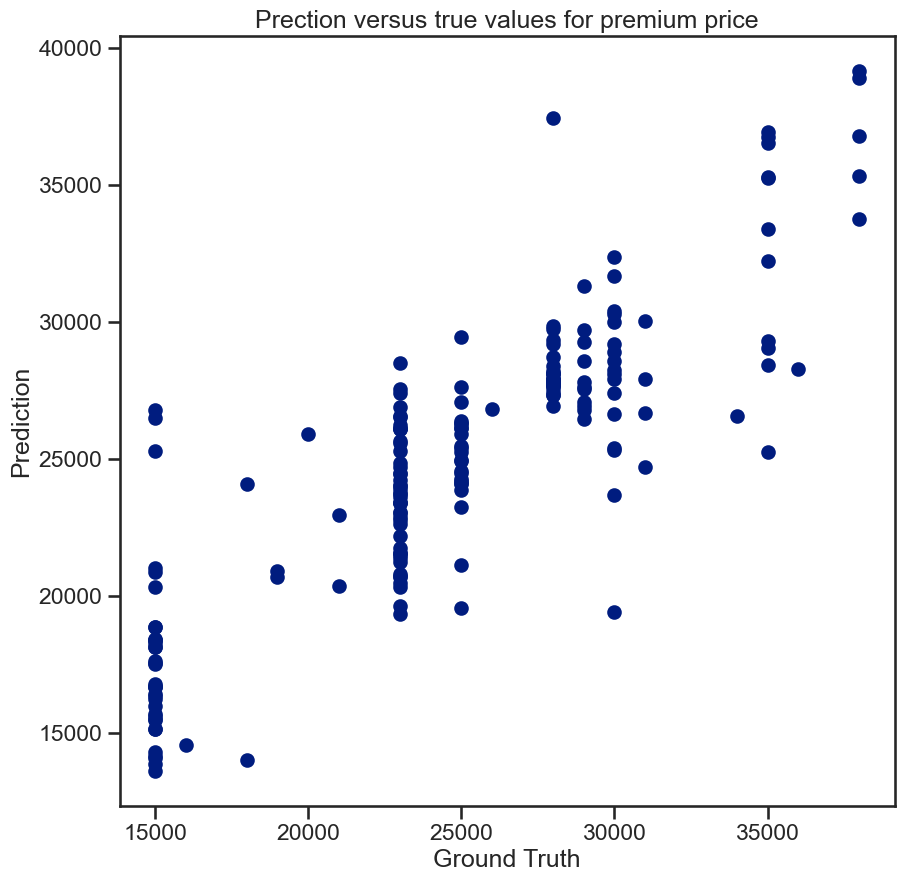

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=y_te_true, y=y_te_pre_true)
ax.set(xlabel='Ground Truth', ylabel='Prediction', title='Prection versus true values for premium price')